In [ ]:
#!pip install yfinance
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

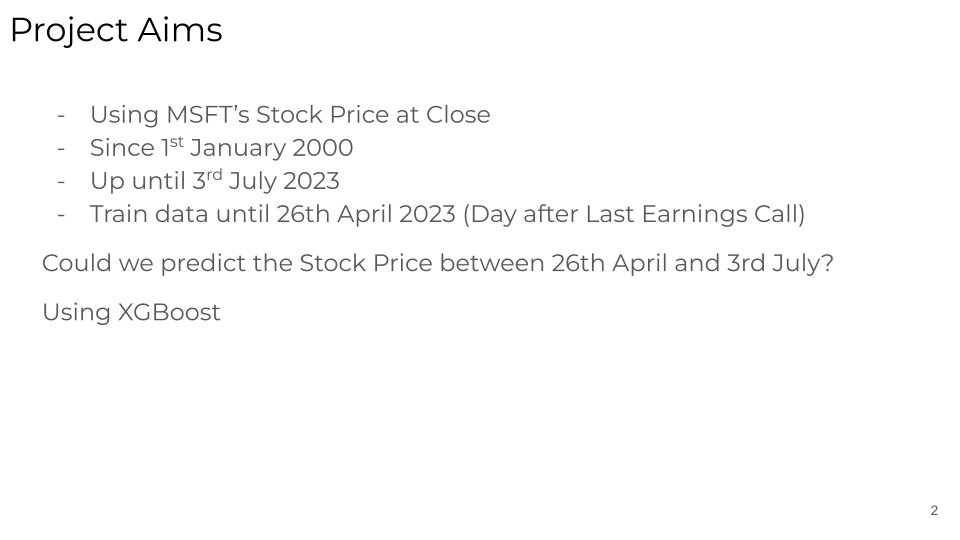

In [ ]:
# Loaded the start date - This is the date from when the data will be uploaded - 1st Jan 2000
start_date = '2000-01-01'
start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')

# We will train the model up until the 3rd of July, and then predict on the 10th of July

# The end_date is the last day for which we will load training data - 3rd July 2023
end_date = '2023-07-03'
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')

# The target date is the date for which we want to predict the stock price - 10th July 2023
target_date = '2023-07-10'
target_date_dt = datetime.strptime(target_date, '%Y-%m-%d')

### Loading MSFT Data up until 10th July

In [ ]:
# Choose the ticker symbol
tickerSymbol = 'MSFT'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
# We want to load the data up until the 10th July - we will restrict the dataframe to the 3rd July later
msft = tickerData.history(period='1d', start= start_date_dt, end= (target_date_dt + timedelta(days = 1))) #We need to add 1 day to the end of the range so that the time range goes up to the desired target date

# Visualise
msft

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-05:00,36.384112,36.771589,34.717960,36.132252,53228400,0.0,0.0
2000-01-04 00:00:00-05:00,35.202309,36.306619,34.795458,34.911701,54119000,0.0,0.0
2000-01-05 00:00:00-05:00,34.446724,36.074129,33.904256,35.279800,64059600,0.0,0.0
2000-01-06 00:00:00-05:00,34.776073,35.299167,33.594268,34.097988,54976600,0.0,0.0
2000-01-07 00:00:00-05:00,33.671774,34.795458,33.264923,34.543598,62013600,0.0,0.0
...,...,...,...,...,...,...,...
2023-07-03 00:00:00-04:00,337.787794,339.490717,335.178630,336.592743,12508700,0.0,0.0
2023-07-05 00:00:00-04:00,333.704728,340.237606,333.346231,336.752075,18172400,0.0,0.0
2023-07-06 00:00:00-04:00,335.905603,341.572083,334.113056,339.859192,28161200,0.0,0.0


In [ ]:
# Let's isolate the column with the closing price, as we will not be using be using any of the other columns in this data frame
msft = msft[['Close']]

# Resetting the date index so that we can manipulate the daytime object to contain a year-month-day formatted date
# msft = msft.reset_index()
# msft['Date'] = msft['Date'].dt.date
# msft = msft.set_index('Date')

# Send the Close column is what we are going to use as an indicator for the price, we can rename it for greater clarity
msft = msft.rename(columns = {'Close': 'Price'})
msft

,Price
Date,
2000-01-03 00:00:00-05:00,36.132252
2000-01-04 00:00:00-05:00,34.911701
2000-01-05 00:00:00-05:00,35.279800
2000-01-06 00:00:00-05:00,34.097988
2000-01-07 00:00:00-05:00,34.543598
...,...
2023-07-03 00:00:00-04:00,336.592743
2023-07-05 00:00:00-04:00,336.752075
2023-07-06 00:00:00-04:00,339.859192


In [ ]:
msft.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5916 entries, 2000-01-03 00:00:00-05:00 to 2023-07-10 00:00:00-04:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   5916 non-null   float64
dtypes: float64(1)
memory usage: 92.4 KB


Now, let's restrict the data frame to the last day of trading that we will feed into our model, eg the `end_date` of the 3rd July 2023



In [ ]:
# Then, restrict the df
df = msft[:end_date]

# Remove the timezone information and set the time to midnight
df.index = df.index.tz_convert(None).normalize()

df

,Price
Date,
2000-01-03,36.132252
2000-01-04,34.911701
2000-01-05,35.279800
2000-01-06,34.097988
2000-01-07,34.543598
...,...
2023-06-27,333.186890
2023-06-28,334.461609
2023-06-29,333.664886


In [ ]:
df['Price'].iloc[0:3]

Date
2000-01-03    36.132252
2000-01-04    34.911701
2000-01-05    35.279800
Name: Price, dtype: float64

# Initialise randomised sampling to create an input and output array

In [ ]:
# Initialize lists to store input and output sequences
input_sequences = []
output_sequences = []

In [ ]:
# Define the sequence length (12 for input, 13 for output)
sequence_length = 12

In [ ]:
# Iterate through the data to create sequences
for i in range(len(df['Price']) - sequence_length - 1): #Iterate through the first 5899 rowss and leave the last 13 rows alone
    input_seq = df['Price'].iloc[i:i + sequence_length]  # Get (the rolling) 12 rows from the Price column and add them to a Pandas Series called `input seq`.
    output_seq = df['Price'].iloc[i + sequence_length]  # Get the corresponding 13th output value and add it to a Pandas Series called `output_seq`
    input_sequences.append(list(input_seq))
    output_sequences.append(output_seq)

In [ ]:
# Convert the lists to NumPy arrays
input_sequences = np.array(input_sequences)
output_sequences = np.array(output_sequences)

## Separate the input & output sequences into Training and Testing

In [ ]:
# Pick the % of the dataset that we want to set aside for testing
pct_testing = 20

# Convert it into an index location in the input array for slicing
slicing_index = len(input_sequences) * pct_testing/100  #this makes a float so it needs to be casted onto an `int`
slicing_index = int(slicing_index)


# Slice the input and output sequences to separate training and test data
X_train = input_sequences[:-slicing_index]
y_train = output_sequences[:-slicing_index]
X_test = input_sequences[-slicing_index:]
y_test = output_sequences[-slicing_index:]

### What this is doing:
![](https://drive.google.com/uc?export=view&id=1DmAs743q67xDinxbiVE_DLVZn61IjtLo)

In [ ]:
print('X_train has shape ', X_train.shape, ' and its data is', X_train)
print('y_train has shape ', y_train.shape, ' and its data is', y_train)
print('X_test has shape ', X_test.shape, ' and its data is', X_test)
print('y_test has shape ', y_test.shape, ' and its data is', y_test)

X_train has shape  (4720, 12)  and its data is [[ 36.13225174  34.9117012   35.27980042 ...  34.79546738  35.74477768
   33.16806793]
 [ 34.9117012   35.27980042  34.09798813 ...  35.74477768  33.16806793
   32.85808182]
 [ 35.27980042  34.09798813  34.54359818 ...  33.16806793  32.85808182
   32.1606102 ]
 ...
 [108.87576294 108.89469147 106.64434052 ... 101.73713684 104.95186615
  104.67767334]
 [108.89469147 106.64434052 106.02033234 ... 104.95186615 104.67767334
  102.58811188]
 [106.64434052 106.02033234 104.81007385 ... 104.67767334 102.58811188
  102.73937988]]
y_train has shape  (4720,)  and its data is [ 32.85808182  32.1606102   31.38566589 ... 102.58811188 102.73937988
 103.65652466]
X_test has shape  (1179, 12)  and its data is [[106.02033234 104.81007385 106.14325714 ... 102.58811188 102.73937988
  103.65652466]
 [104.81007385 106.14325714 100.37561798 ... 102.73937988 103.65652466
  102.20989227]
 [106.14325714 100.37561798 100.13922119 ... 103.65652466 102.20989227
   96

# Create MLP Regressor Model

## Create a Preliminary Model and Observe Performance

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
model = MLPRegressor()

In [ ]:
model.fit(X_train, y_train)

MLPRegressor()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print(y_pred)
print(y_pred.shape)

[104.27060465 104.3094807   99.63845043 ... 334.61655142 335.2834799
 334.95233276]
(1179,)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"RMSE: {rmse}")
print(f"R-squared (R2) Score: {r2}")


Mean Squared Error (MSE): 21.99862195171822
Mean Absolute Error (MAE): 3.341904224056788
RMSE: 4.6902688570825255
R-squared (R2) Score: 0.9954088114245374


### Compare model predictions with `y_test`

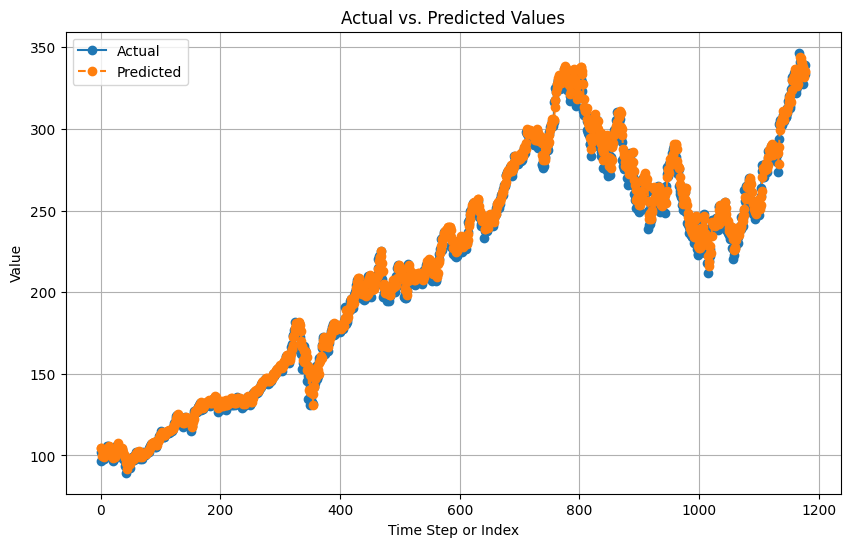

In [ ]:
# Create an array for the x-axis (indices or time steps)
x = np.arange(len(y_test))

# Create a line plot for y_pred and y_test
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(x, y_test, label='Actual', marker='o', linestyle='-')
plt.plot(x, y_pred, label='Predicted', marker='o', linestyle='--')

# Add labels and a legend
plt.xlabel('Time Step or Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()


In [ ]:
score = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE Score on Test set: {score:0.2f}')
print(f'R^2 Score on Test set: {r2:0.2f}')

RMSE Score on Test set: 4.69
R^2 Score on Test set: 1.00


## Cross-Validation of Regressor Parameters

In [ ]:
df = df.astype(float)

In [ ]:
from sklearn.preprocessing import StandardScaler
# Use MinMaxScaler to scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)  # Scaling the  data


In [ ]:
df_scaled.shape

(5912, 1)

In [ ]:
df.shape

(5912, 1)

In [ ]:
# Initialize lists to store input and output sequences
input_sequences = []
output_sequences = []

# Define the sequence length (12 for input, 13 for output)
sequence_length = 12

# Iterate through the data to create sequences
for i in range(len(df_scaled) - sequence_length - 1): #Iterate through the first 5899 rowss and leave the last 13 rows alone
    input_seq = df_scaled[i:i + sequence_length]  # Get (the rolling) 12 rows from the Price column and add them to a Pandas Series called `input seq`.
    output_seq = df_scaled[i + sequence_length]  # Get the corresponding 13th output value and add it to a Pandas Series called `output_seq`
    input_sequences.append(list(input_seq))
    output_sequences.append(output_seq)

# Convert the lists to NumPy arrays
input_sequences = np.array(input_sequences)
output_sequences = np.array(output_sequences)

# Pick the % of the dataset that we want to set aside for testing
pct_testing = 20

# Convert it into an index location in the input array for slicing
slicing_index = len(input_sequences) * pct_testing/100  #this makes a float so it needs to be casted onto an `int`
slicing_index = int(slicing_index)


# Slice the input and output sequences to separate training and test data
X_train_cv = input_sequences[:-slicing_index]
y_train_cv = output_sequences[:-slicing_index]
X_test_cv = input_sequences[-slicing_index:]
y_test_cv = output_sequences[-slicing_index:]

In [ ]:
# Check the dimensions of X_train
X_train_cv.shape

(4720, 12, 1)

In [ ]:
# It needs to be a 2D numpy array for sklearns's MLP Regressor. Therefore, we need to flatten it.
# Flatten X_train
X_train_cv = X_train_cv.reshape((X_train_cv.shape[0], -1))  # Reshape to (4720, 12 * 1)
X_test_cv = X_test_cv.reshape((X_test_cv.shape[0], -1))

In [ ]:
# Check the dimensions of X_train
X_train_cv.shape

(4720, 12)

In [ ]:
# Good! That's a 2D array

In [ ]:
# Check the dimensions of y_train
y_train_cv.shape

(4720, 1)

In [ ]:
# It needs to be a 1D numpy array for sklearns's MLP Regressor. Therefore, we need to flatten it.
# Flatten y_train
y_train_cv = y_train_cv.ravel()
y_test_cv = y_test_cv.ravel()

In [ ]:
# Check the dimensions of y_train
y_train_cv.shape

(4720,)

In [ ]:
param_grid = {'max_iter': [12, 15, 17, 20, 22, 24, 26],
              'hidden_layer_sizes': [(18,),(20,),(22,),(24,),(26,),(28,),(30,)]}

In [ ]:
# %%time
# regressor = GridSearchCV(
#     estimator = MLPRegressor(),
#     param_grid = param_grid,
#     n_jobs = 4,
#     error_score='raise'
# )
# regressor.fit(X_train, y_train) #X_train and y_train have been scaled using StandardScaler
# print(regressor.best_score_)
# print(regressor.best_estimator_)

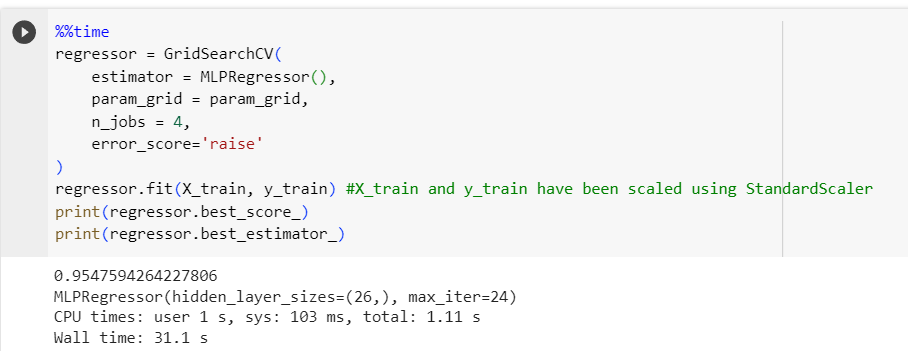

In [ ]:
best_layer_size = (26,)
best_iter_max = 24

# Now

In [ ]:
%%time
model_cv = MLPRegressor(hidden_layer_sizes = best_layer_size,
                        max_iter = best_iter_max
                        )

model_cv.fit(X_train_cv, y_train_cv)
y_pred_cv = model_cv.predict(X_test_cv)
print(y_pred_cv)
print(y_pred_cv.shape)

[0.44827223 0.43805283 0.38589613 ... 3.10958158 3.13260085 3.08697244]
(1179,)
CPU times: user 130 ms, sys: 0 ns, total: 130 ms
Wall time: 127 ms


In [ ]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_cv, y_pred_cv)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_cv, y_pred_cv)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R-squared (R2) score
r2 = r2_score(y_test_cv, y_pred_cv)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"RMSE: {rmse}")
print(f"R-squared (R2) Score: {r2}")

Mean Squared Error (MSE): 0.018693666938707987
Mean Absolute Error (MAE): 0.10934890642528299
RMSE: 0.13672478538548885
R-squared (R2) Score: 0.9736657783656015


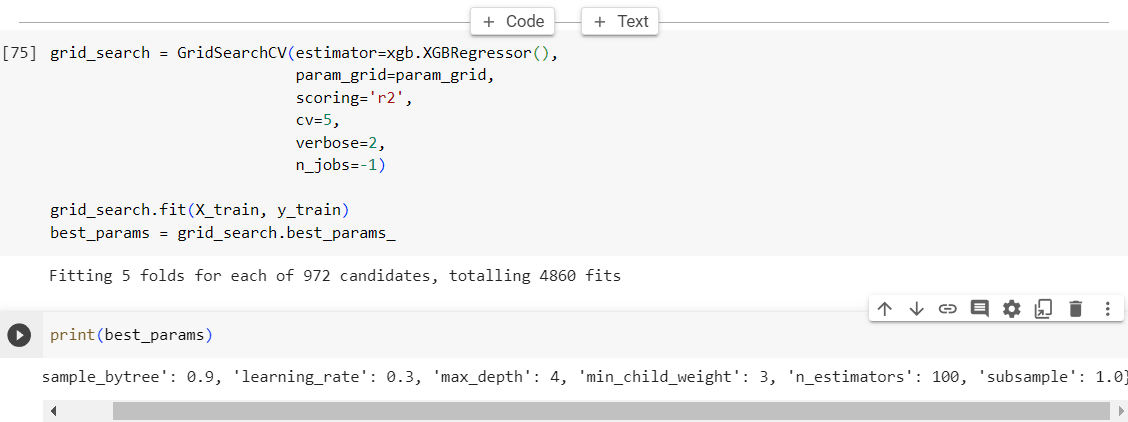

The output of this cell has been saved in a new variable `best_params_saved_1st`

In [ ]:
best_params_saved_1st = {'colsample_bytree': 0.9, 'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}

In [ ]:
print(best_params_saved_1st)

{'colsample_bytree': 0.9, 'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


In [ ]:
param_grid_2nd = {
    'learning_rate': [0.25, 0.3, 0.4, 0.5],
    'max_depth': [4],
    'n_estimators': [50, 75, 100],
    'min_child_weight': [2, 3, 4],
    'subsample': [0.95, 0.975, 1.0],
    'colsample_bytree': [0.85, 0.9, 0.95]
}

In [ ]:
# grid_search = GridSearchCV(estimator=xgb.XGBRegressor(),
#                            param_grid=param_grid_2nd,
#                            scoring='r2',
#                            cv=5,
#                            verbose=2,
#                            n_jobs=-1)

# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_

In [ ]:
# print(best_params)

The above code took 14 minutes to run and had the following output:
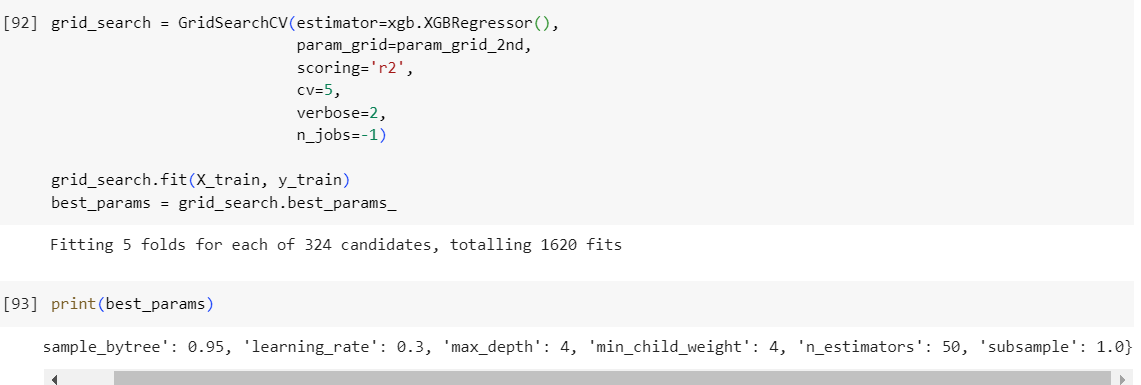

These parameters have been saved in the variable `best_params_2nd`.

In [ ]:
best_params_2nd = {'colsample_bytree': 0.95, 'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 50, 'subsample': 1.0}

Now, let's use these parameters to fit our model

In [ ]:
best_model = xgb.XGBRegressor(**best_params_2nd)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [ ]:
print(f'RMSE Score on Test set: {rmse:0.2f}')
print(f'R^2 Score on Test set: {r2:0.2f}')

RMSE Score on Test set: 128.12
R^2 Score on Test set: -2.43


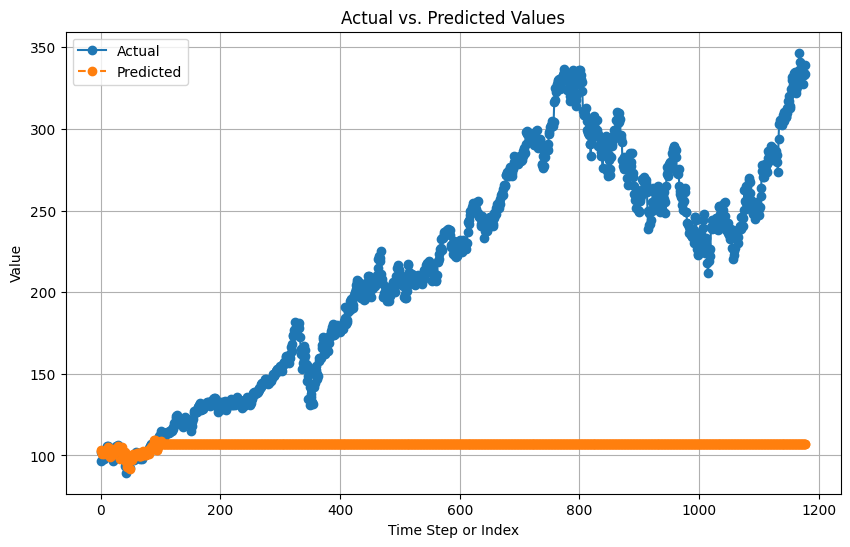

In [ ]:
# Create an array for the x-axis (indices or time steps)
x = np.arange(len(y_test))

# Create a line plot for y_pred and y_test
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(x, y_test, label='Actual', marker='o', linestyle='-')
plt.plot(x, y_pred, label='Predicted', marker='o', linestyle='--')

# Add labels and a legend
plt.xlabel('Time Step or Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()

# Predict the price on 10th July 2023 off the out-of-the-box model

In [ ]:
trading_dates = msft[end_date:target_date].index.tz_convert(None).normalize()
trading_dates

DatetimeIndex(['2023-07-03', '2023-07-05', '2023-07-06', '2023-07-07',
               '2023-07-10'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [ ]:
# Extend the sequences up to the 10th of July
extended_input_sequences = input_sequences.copy()  # Make a copy of the input sequences
extended_output_sequences = output_sequences.copy()  # Make a copy of the output sequences

In [ ]:
for date in trading_dates:
    # Predict for the next day
    prediction = model.predict(extended_input_sequences[-1].reshape(1, -1))  # Predict for the last sequence
    extended_input_sequences = np.vstack((extended_input_sequences, np.append(extended_input_sequences[-1, 1:], prediction)))
    extended_output_sequences = np.append(extended_output_sequences, prediction)

# Print or use the predictions for July 4th to July 10th
print("Predictions for July 10th:", extended_output_sequences[-1])

ValueError: ignored